## autoencoder + transformer to handle spatial and temporal information

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18
from torchvision import datasets, transforms, models
import matplotlib.image as image

import sys
sys.path.append('../../../../Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning/src/utils')
sys.path.append('../../../src/DL')
from viz import show_images
from hdf5_dataset import hdf5_dataset
from build_model import VideoRegressionModel
from trainer import ModelTrainer

In [2]:
bs = 16
num_workers = 4

# imagenet
train_ds = hdf5_dataset('../../../datasets/MultiParams_2_36frames_analytical_train.h5', transform=transforms.ToTensor(),
                        data_key='plumes', label_key='normalized_labels_all_train')
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=num_workers)

valid_ds = hdf5_dataset('../../../datasets/MultiParams_2_36frames_analytical_test.h5', transform=transforms.ToTensor(),
                        data_key='plumes', label_key='normalized_labels_all_test')
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, num_workers=num_workers)

batch = next(iter(train_dl))
images, labels = batch
print(images.shape, labels.shape, labels)

torch.Size([16, 34, 1, 250, 400]) torch.Size([16, 5]) tensor([[0.2500, 0.3440, 0.3042, 0.5252, 0.6346],
        [1.0000, 0.6400, 0.3898, 0.4175, 0.4712],
        [0.7500, 0.6400, 0.3763, 0.5743, 0.4519],
        [0.5000, 0.6400, 0.3613, 0.3917, 0.4423],
        [0.5000, 0.6400, 0.3613, 0.3806, 0.5577],
        [0.5000, 0.6400, 0.3613, 0.3914, 0.5769],
        [1.0000, 0.6400, 0.3898, 0.4211, 0.4519],
        [0.2500, 0.8520, 0.1277, 0.3878, 0.5000],
        [0.5000, 0.6400, 0.3613, 0.3884, 0.4231],
        [0.2500, 1.0000, 1.0000, 0.9757, 0.8558],
        [0.0000, 0.6400, 0.4151, 0.1406, 0.3077],
        [0.7500, 0.6400, 0.3763, 0.5416, 0.6923],
        [0.7500, 0.6400, 0.3763, 0.5721, 0.4808],
        [0.7500, 0.6400, 0.3763, 0.5819, 0.5000],
        [0.2500, 0.0000, 0.0000, 0.4694, 0.5288],
        [0.5000, 0.6400, 0.3613, 0.3951, 0.4615]], dtype=torch.float64)


In [3]:
model = VideoRegressionModel(num_frames=34, num_channels=1, hidden_dim=512, num_layers=4, num_heads=8, mlp_dim=2048, output_dim=5)
# model.load_state_dict(torch.load('../../../datasets/GrowthConditions_PlumeMetrics_ae_transformer/epoch-36.pt'))
gr, reconstructed = model(images)
print(gr.shape, reconstructed.shape)  # Should be (batch_size, output_dim)

torch.Size([16, 5]) torch.Size([16, 34, 1, 250, 400])


In [4]:
device = torch.device('cuda:0')
lr = 1e-3
start = 0
epochs = 500
model = nn.parallel.DataParallel(model, device_ids=[0, 1]).to(device)

def custom_loss_calculator(outputs, inputs, labels):
    losses = {}
    predictions, reconstructed = outputs

    loss_growth_rate = F.mse_loss(predictions, labels)
    loss_reconstruction = F.mse_loss(reconstructed, inputs)
    losses['loss_growth_rate'] = loss_growth_rate.item()
    losses['loss_reconstruction'] = loss_reconstruction.item()

    total_loss = loss_growth_rate + loss_reconstruction
    losses['Total_loss'] = total_loss

    return losses

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, steps_per_epoch=len(train_dl))

trainer = ModelTrainer(model, custom_loss_calculator, optimizer, device, scheduler)
history = trainer.train_epochs(train_dl, valid_dl_list=[valid_dl], valid_name_list=['validation'], 
                               epochs=epochs, model_dir='../../../datasets/GrowthConditions_PlumeMetrics_ae_transformer/')

Epoch: 1/500


  0%|          | 0/176 [00:00<?, ?it/s]c:\Users\yig319\Anaconda3\envs\plume\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
c:\Users\yig319\Anaconda3\envs\plume\Lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn("PyTorch is not compiled with NCCL support")
c:\Users\yig319\Anaconda3\envs\plume\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 176/176 [0

Training:
  loss_growth_rate: 0.0033
  loss_reconstruction: 0.0043
  Total_loss: 0.0076


100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


validation:
  loss_growth_rate: 0.0080
  loss_reconstruction: 0.0023
  Total_loss: 0.0103
Epoch: 2/500


100%|██████████| 176/176 [02:28<00:00,  1.18it/s]


Training:
  loss_growth_rate: 0.0015
  loss_reconstruction: 0.0021
  Total_loss: 0.0036


100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


validation:
  loss_growth_rate: 0.0023
  loss_reconstruction: 0.0023
  Total_loss: 0.0046
Epoch: 3/500


100%|██████████| 176/176 [02:31<00:00,  1.16it/s]


Training:
  loss_growth_rate: 0.0007
  loss_reconstruction: 0.0021
  Total_loss: 0.0028


100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


validation:
  loss_growth_rate: 0.0020
  loss_reconstruction: 0.0023
  Total_loss: 0.0043
Epoch: 4/500


100%|██████████| 176/176 [02:38<00:00,  1.11it/s]


Training:
  loss_growth_rate: 0.0004
  loss_reconstruction: 0.0021
  Total_loss: 0.0025


100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


validation:
  loss_growth_rate: 0.0063
  loss_reconstruction: 0.0023
  Total_loss: 0.0086
Epoch: 5/500


100%|██████████| 176/176 [02:48<00:00,  1.04it/s]


Training:
  loss_growth_rate: 0.0003
  loss_reconstruction: 0.0020
  Total_loss: 0.0023


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]


validation:
  loss_growth_rate: 0.0074
  loss_reconstruction: 0.0022
  Total_loss: 0.0095
Epoch: 6/500


100%|██████████| 176/176 [02:57<00:00,  1.01s/it]


Training:
  loss_growth_rate: 0.0003
  loss_reconstruction: 0.0011
  Total_loss: 0.0014


100%|██████████| 14/14 [00:12<00:00,  1.10it/s]


validation:
  loss_growth_rate: 0.0079
  loss_reconstruction: 0.0015
  Total_loss: 0.0094
Epoch: 7/500


100%|██████████| 176/176 [03:09<00:00,  1.08s/it]


Training:
  loss_growth_rate: 0.0002
  loss_reconstruction: 0.0005
  Total_loss: 0.0007


100%|██████████| 14/14 [00:13<00:00,  1.02it/s]


validation:
  loss_growth_rate: 0.0069
  loss_reconstruction: 0.0035
  Total_loss: 0.0103
Epoch: 8/500


100%|██████████| 176/176 [03:22<00:00,  1.15s/it]


Training:
  loss_growth_rate: 0.0002
  loss_reconstruction: 0.0001
  Total_loss: 0.0003


100%|██████████| 14/14 [00:14<00:00,  1.07s/it]


validation:
  loss_growth_rate: 0.0096
  loss_reconstruction: 0.0014
  Total_loss: 0.0110
Epoch: 9/500


100%|██████████| 176/176 [03:43<00:00,  1.27s/it]


Training:
  loss_growth_rate: 0.0002
  loss_reconstruction: 0.0001
  Total_loss: 0.0003


100%|██████████| 14/14 [00:17<00:00,  1.23s/it]


validation:
  loss_growth_rate: 0.0056
  loss_reconstruction: 0.0012
  Total_loss: 0.0069
Epoch: 10/500


100%|██████████| 176/176 [04:10<00:00,  1.43s/it]


Training:
  loss_growth_rate: 0.0002
  loss_reconstruction: 0.0001
  Total_loss: 0.0003


100%|██████████| 14/14 [00:20<00:00,  1.48s/it]


validation:
  loss_growth_rate: 0.0038
  loss_reconstruction: 0.0011
  Total_loss: 0.0049
Epoch: 11/500


100%|██████████| 176/176 [05:01<00:00,  1.72s/it]


Training:
  loss_growth_rate: 0.0002
  loss_reconstruction: 0.0001
  Total_loss: 0.0002


100%|██████████| 14/14 [00:24<00:00,  1.77s/it]


validation:
  loss_growth_rate: 0.0063
  loss_reconstruction: 0.0017
  Total_loss: 0.0080
Epoch: 12/500


100%|██████████| 176/176 [05:44<00:00,  1.96s/it]


Training:
  loss_growth_rate: 0.0003
  loss_reconstruction: 0.0001
  Total_loss: 0.0004


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


validation:
  loss_growth_rate: 0.0047
  loss_reconstruction: 0.0020
  Total_loss: 0.0067
Epoch: 13/500


100%|██████████| 176/176 [06:22<00:00,  2.17s/it]


Training:
  loss_growth_rate: 0.0002
  loss_reconstruction: 0.0001
  Total_loss: 0.0003


100%|██████████| 14/14 [00:33<00:00,  2.37s/it]


validation:
  loss_growth_rate: 0.0067
  loss_reconstruction: 0.0017
  Total_loss: 0.0085
Epoch: 14/500


100%|██████████| 176/176 [07:24<00:00,  2.52s/it]


Training:
  loss_growth_rate: 0.0002
  loss_reconstruction: 0.0001
  Total_loss: 0.0002


100%|██████████| 14/14 [00:37<00:00,  2.68s/it]


validation:
  loss_growth_rate: 0.0063
  loss_reconstruction: 0.0016
  Total_loss: 0.0079
Epoch: 15/500


100%|██████████| 176/176 [08:19<00:00,  2.84s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0001
  Total_loss: 0.0002


100%|██████████| 14/14 [00:42<00:00,  3.05s/it]


validation:
  loss_growth_rate: 0.0042
  loss_reconstruction: 0.0009
  Total_loss: 0.0051
Epoch: 16/500


100%|██████████| 176/176 [09:14<00:00,  3.15s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0002


100%|██████████| 14/14 [00:46<00:00,  3.34s/it]


validation:
  loss_growth_rate: 0.0044
  loss_reconstruction: 0.0014
  Total_loss: 0.0058
Epoch: 17/500


100%|██████████| 176/176 [09:59<00:00,  3.40s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0002


100%|██████████| 14/14 [00:50<00:00,  3.60s/it]


validation:
  loss_growth_rate: 0.0017
  loss_reconstruction: 0.0008
  Total_loss: 0.0025
Epoch: 18/500


100%|██████████| 176/176 [10:34<00:00,  3.61s/it]


Training:
  loss_growth_rate: 0.0003
  loss_reconstruction: 0.0001
  Total_loss: 0.0004


100%|██████████| 14/14 [00:54<00:00,  3.88s/it]


validation:
  loss_growth_rate: 0.0027
  loss_reconstruction: 0.0010
  Total_loss: 0.0037
Epoch: 19/500


100%|██████████| 176/176 [11:15<00:00,  3.84s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0002


100%|██████████| 14/14 [00:58<00:00,  4.18s/it]


validation:
  loss_growth_rate: 0.0070
  loss_reconstruction: 0.0014
  Total_loss: 0.0084
Epoch: 20/500


100%|██████████| 176/176 [11:44<00:00,  4.00s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0002


100%|██████████| 14/14 [00:58<00:00,  4.17s/it]


validation:
  loss_growth_rate: 0.0056
  loss_reconstruction: 0.0012
  Total_loss: 0.0068
Epoch: 21/500


100%|██████████| 176/176 [12:27<00:00,  4.25s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0001


100%|██████████| 14/14 [01:04<00:00,  4.59s/it]


validation:
  loss_growth_rate: 0.0076
  loss_reconstruction: 0.0016
  Total_loss: 0.0092
Epoch: 22/500


100%|██████████| 176/176 [13:05<00:00,  4.46s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0002


100%|██████████| 14/14 [01:08<00:00,  4.88s/it]


validation:
  loss_growth_rate: 0.0076
  loss_reconstruction: 0.0018
  Total_loss: 0.0094
Epoch: 23/500


100%|██████████| 176/176 [13:47<00:00,  4.70s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0002


100%|██████████| 14/14 [01:09<00:00,  4.98s/it]


validation:
  loss_growth_rate: 0.0046
  loss_reconstruction: 0.0013
  Total_loss: 0.0059
Epoch: 24/500


100%|██████████| 176/176 [14:27<00:00,  4.93s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0001


100%|██████████| 14/14 [01:14<00:00,  5.30s/it]


validation:
  loss_growth_rate: 0.0066
  loss_reconstruction: 0.0016
  Total_loss: 0.0082
Epoch: 25/500


100%|██████████| 176/176 [15:31<00:00,  5.29s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0001


100%|██████████| 14/14 [01:14<00:00,  5.35s/it]


validation:
  loss_growth_rate: 0.0098
  loss_reconstruction: 0.0008
  Total_loss: 0.0107
Epoch: 26/500


100%|██████████| 176/176 [15:57<00:00,  5.44s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0001


100%|██████████| 14/14 [01:26<00:00,  6.15s/it]


validation:
  loss_growth_rate: 0.0079
  loss_reconstruction: 0.0014
  Total_loss: 0.0092
Epoch: 27/500


100%|██████████| 176/176 [17:19<00:00,  5.91s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0001


100%|██████████| 14/14 [01:32<00:00,  6.57s/it]


validation:
  loss_growth_rate: 0.0098
  loss_reconstruction: 0.0012
  Total_loss: 0.0110
Epoch: 28/500


100%|██████████| 176/176 [17:30<00:00,  5.97s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0001


100%|██████████| 14/14 [01:26<00:00,  6.16s/it]


validation:
  loss_growth_rate: 0.0068
  loss_reconstruction: 0.0011
  Total_loss: 0.0078
Epoch: 29/500


100%|██████████| 176/176 [19:26<00:00,  6.63s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0001


100%|██████████| 14/14 [01:35<00:00,  6.81s/it]


validation:
  loss_growth_rate: 0.0089
  loss_reconstruction: 0.0016
  Total_loss: 0.0105
Epoch: 30/500


100%|██████████| 176/176 [20:15<00:00,  6.90s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0001


100%|██████████| 14/14 [01:52<00:00,  8.01s/it]


validation:
  loss_growth_rate: 0.0082
  loss_reconstruction: 0.0013
  Total_loss: 0.0096
Epoch: 31/500


100%|██████████| 176/176 [21:52<00:00,  7.46s/it]


Training:
  loss_growth_rate: 0.0003
  loss_reconstruction: 0.0001
  Total_loss: 0.0004


100%|██████████| 14/14 [01:47<00:00,  7.69s/it]


validation:
  loss_growth_rate: 0.0053
  loss_reconstruction: 0.0019
  Total_loss: 0.0072
Epoch: 32/500


100%|██████████| 176/176 [21:04<00:00,  7.18s/it]


Training:
  loss_growth_rate: 0.0002
  loss_reconstruction: 0.0001
  Total_loss: 0.0003


100%|██████████| 14/14 [01:49<00:00,  7.86s/it]


validation:
  loss_growth_rate: 0.0074
  loss_reconstruction: 0.0015
  Total_loss: 0.0089
Epoch: 33/500


100%|██████████| 176/176 [22:04<00:00,  7.52s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0002


100%|██████████| 14/14 [01:54<00:00,  8.16s/it]


validation:
  loss_growth_rate: 0.0024
  loss_reconstruction: 0.0015
  Total_loss: 0.0039
Epoch: 34/500


100%|██████████| 176/176 [23:12<00:00,  7.91s/it]


Training:
  loss_growth_rate: 0.0003
  loss_reconstruction: 0.0001
  Total_loss: 0.0004


100%|██████████| 14/14 [02:00<00:00,  8.58s/it]


validation:
  loss_growth_rate: 0.0112
  loss_reconstruction: 0.0019
  Total_loss: 0.0131
Epoch: 35/500


100%|██████████| 176/176 [25:23<00:00,  8.65s/it]


Training:
  loss_growth_rate: 0.0007
  loss_reconstruction: 0.0001
  Total_loss: 0.0008


100%|██████████| 14/14 [02:16<00:00,  9.73s/it]


validation:
  loss_growth_rate: 0.0172
  loss_reconstruction: 0.0043
  Total_loss: 0.0214
Epoch: 36/500


100%|██████████| 176/176 [26:03<00:00,  8.88s/it]


Training:
  loss_growth_rate: 0.0004
  loss_reconstruction: 0.0001
  Total_loss: 0.0004


100%|██████████| 14/14 [02:04<00:00,  8.86s/it]


validation:
  loss_growth_rate: 0.0063
  loss_reconstruction: 0.0024
  Total_loss: 0.0086
Epoch: 37/500


100%|██████████| 176/176 [25:48<00:00,  8.80s/it]


Training:
  loss_growth_rate: 0.0004
  loss_reconstruction: 0.0001
  Total_loss: 0.0005


100%|██████████| 14/14 [02:13<00:00,  9.52s/it]


validation:
  loss_growth_rate: 0.0018
  loss_reconstruction: 0.0014
  Total_loss: 0.0032
Epoch: 38/500


100%|██████████| 176/176 [27:04<00:00,  9.23s/it]


Training:
  loss_growth_rate: 0.0002
  loss_reconstruction: 0.0001
  Total_loss: 0.0003


100%|██████████| 14/14 [02:12<00:00,  9.45s/it]


validation:
  loss_growth_rate: 0.0028
  loss_reconstruction: 0.0023
  Total_loss: 0.0051
Epoch: 39/500


100%|██████████| 176/176 [27:51<00:00,  9.49s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0001


100%|██████████| 14/14 [02:24<00:00, 10.35s/it]


validation:
  loss_growth_rate: 0.0112
  loss_reconstruction: 0.0018
  Total_loss: 0.0129
Epoch: 40/500


100%|██████████| 176/176 [29:00<00:00,  9.89s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0001


100%|██████████| 14/14 [02:26<00:00, 10.49s/it]


validation:
  loss_growth_rate: 0.0071
  loss_reconstruction: 0.0020
  Total_loss: 0.0092
Epoch: 41/500


100%|██████████| 176/176 [29:49<00:00, 10.17s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0001


100%|██████████| 14/14 [02:33<00:00, 10.99s/it]


validation:
  loss_growth_rate: 0.0136
  loss_reconstruction: 0.0020
  Total_loss: 0.0156
Epoch: 42/500


100%|██████████| 176/176 [31:11<00:00, 10.63s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0002


100%|██████████| 14/14 [02:39<00:00, 11.38s/it]


validation:
  loss_growth_rate: 0.0170
  loss_reconstruction: 0.0014
  Total_loss: 0.0184
Epoch: 43/500


100%|██████████| 176/176 [32:16<00:00, 11.01s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0001


100%|██████████| 14/14 [02:52<00:00, 12.30s/it]


validation:
  loss_growth_rate: 0.0086
  loss_reconstruction: 0.0015
  Total_loss: 0.0102
Epoch: 44/500


100%|██████████| 176/176 [36:05<00:00, 12.31s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0001


100%|██████████| 14/14 [03:28<00:00, 14.88s/it]


validation:
  loss_growth_rate: 0.0132
  loss_reconstruction: 0.0015
  Total_loss: 0.0147
Epoch: 45/500


100%|██████████| 176/176 [36:49<00:00, 12.56s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0001


100%|██████████| 14/14 [03:01<00:00, 12.96s/it]


validation:
  loss_growth_rate: 0.0087
  loss_reconstruction: 0.0014
  Total_loss: 0.0101
Epoch: 46/500


100%|██████████| 176/176 [35:46<00:00, 12.19s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0001


100%|██████████| 14/14 [03:04<00:00, 13.18s/it]


validation:
  loss_growth_rate: 0.0056
  loss_reconstruction: 0.0014
  Total_loss: 0.0070
Epoch: 47/500


100%|██████████| 176/176 [36:34<00:00, 12.47s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0001


100%|██████████| 14/14 [03:04<00:00, 13.19s/it]


validation:
  loss_growth_rate: 0.0065
  loss_reconstruction: 0.0019
  Total_loss: 0.0085
Epoch: 48/500


100%|██████████| 176/176 [37:45<00:00, 12.87s/it]


Training:
  loss_growth_rate: 0.0001
  loss_reconstruction: 0.0000
  Total_loss: 0.0001


100%|██████████| 14/14 [03:07<00:00, 13.39s/it]


validation:
  loss_growth_rate: 0.0149
  loss_reconstruction: 0.0014
  Total_loss: 0.0163
Epoch: 49/500


100%|██████████| 176/176 [38:32<00:00, 13.14s/it]


Training:
  loss_growth_rate: 0.0009
  loss_reconstruction: 0.0002
  Total_loss: 0.0011


100%|██████████| 14/14 [03:22<00:00, 14.49s/it]


validation:
  loss_growth_rate: 0.0020
  loss_reconstruction: 0.0023
  Total_loss: 0.0043
Epoch: 50/500


100%|██████████| 176/176 [39:31<00:00, 13.48s/it]


Training:
  loss_growth_rate: 0.0035
  loss_reconstruction: 0.0002
  Total_loss: 0.0037


100%|██████████| 14/14 [03:20<00:00, 14.33s/it]


validation:
  loss_growth_rate: 0.0066
  loss_reconstruction: 0.0021
  Total_loss: 0.0087
Epoch: 51/500


100%|██████████| 176/176 [41:18<00:00, 14.08s/it]


Training:
  loss_growth_rate: 0.0033
  loss_reconstruction: 0.0002
  Total_loss: 0.0035


100%|██████████| 14/14 [03:27<00:00, 14.85s/it]


validation:
  loss_growth_rate: 0.0017
  loss_reconstruction: 0.0013
  Total_loss: 0.0030
Epoch: 52/500


100%|██████████| 176/176 [41:25<00:00, 14.12s/it]


Training:
  loss_growth_rate: 0.0036
  loss_reconstruction: 0.0002
  Total_loss: 0.0037


100%|██████████| 14/14 [03:35<00:00, 15.41s/it]


validation:
  loss_growth_rate: 0.0017
  loss_reconstruction: 0.0013
  Total_loss: 0.0031
Epoch: 53/500


100%|██████████| 176/176 [42:53<00:00, 14.62s/it]


Training:
  loss_growth_rate: 0.0036
  loss_reconstruction: 0.0001
  Total_loss: 0.0037


100%|██████████| 14/14 [03:31<00:00, 15.09s/it]


validation:
  loss_growth_rate: 0.0014
  loss_reconstruction: 0.0021
  Total_loss: 0.0036
Epoch: 54/500


100%|██████████| 176/176 [43:49<00:00, 14.94s/it]


Training:
  loss_growth_rate: 0.0036
  loss_reconstruction: 0.0001
  Total_loss: 0.0036


100%|██████████| 14/14 [03:45<00:00, 16.08s/it]


validation:
  loss_growth_rate: 0.0018
  loss_reconstruction: 0.0018
  Total_loss: 0.0036
Epoch: 55/500


100%|██████████| 176/176 [45:52<00:00, 15.64s/it]


Training:
  loss_growth_rate: 0.0036
  loss_reconstruction: 0.0000
  Total_loss: 0.0036


100%|██████████| 14/14 [03:58<00:00, 17.07s/it]


validation:
  loss_growth_rate: 0.0015
  loss_reconstruction: 0.0019
  Total_loss: 0.0034
Epoch: 56/500


100%|██████████| 176/176 [47:18<00:00, 16.13s/it]


Training:
  loss_growth_rate: 0.0035
  loss_reconstruction: 0.0000
  Total_loss: 0.0036


100%|██████████| 14/14 [04:01<00:00, 17.24s/it]


validation:
  loss_growth_rate: 0.0017
  loss_reconstruction: 0.0029
  Total_loss: 0.0046
Epoch: 57/500


100%|██████████| 176/176 [48:16<00:00, 16.46s/it]


Training:
  loss_growth_rate: 0.0035
  loss_reconstruction: 0.0000
  Total_loss: 0.0036


100%|██████████| 14/14 [04:13<00:00, 18.11s/it]


validation:
  loss_growth_rate: 0.0019
  loss_reconstruction: 0.0028
  Total_loss: 0.0047
Epoch: 58/500


100%|██████████| 176/176 [49:41<00:00, 16.94s/it]


Training:
  loss_growth_rate: 0.0035
  loss_reconstruction: 0.0000
  Total_loss: 0.0036


100%|██████████| 14/14 [04:21<00:00, 18.70s/it]


validation:
  loss_growth_rate: 0.0019
  loss_reconstruction: 0.0026
  Total_loss: 0.0045
Epoch: 59/500


 82%|████████▏ | 145/176 [44:46<09:34, 18.53s/it]


KeyboardInterrupt: 

In [7]:
torch.save(model.module.cpu().state_dict(), '../../../datasets/GrowthConditions_PlumeMetrics_ae_transformer/best_model.pt')

In [10]:
model = model.module

In [3]:
device = torch.device('cuda:0')
model = VideoRegressionModel(num_frames=34, num_channels=1, hidden_dim=512, num_layers=4, num_heads=8, mlp_dim=2048, output_dim=5)
model.load_state_dict(torch.load('../../../datasets/GrowthConditions_PlumeMetrics_ae_transformer/best_model.pt'))
model = nn.parallel.DataParallel(model, device_ids=[0, 1]).to(device)

In [4]:
bs = 4
num_workers = 4

# imagenet
train_ds = hdf5_dataset('../../../datasets/MultiParams_2_36frames_analytical_train.h5', transform=transforms.ToTensor(),
                        data_key='plumes', label_key='normalized_labels_all_train')
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=num_workers)

valid_ds = hdf5_dataset('../../../datasets/MultiParams_2_36frames_analytical_test.h5', transform=transforms.ToTensor(),
                        data_key='plumes', label_key='normalized_labels_all_test')
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, num_workers=num_workers)

batch = next(iter(train_dl))
images, labels = batch
print(images.shape, labels.shape, labels)

torch.Size([4, 34, 1, 250, 400]) torch.Size([4, 5]) tensor([[0.7500, 0.6400, 0.3763, 0.5718, 0.5865],
        [0.2500, 0.8520, 0.1277, 0.4102, 0.5192],
        [0.2500, 0.3440, 0.3042, 0.5056, 0.4904],
        [0.2500, 0.8520, 0.1277, 0.4058, 0.7212]], dtype=torch.float64)


torch.Size([4, 5]) torch.Size([4, 5]) torch.Size([4, 34, 1, 250, 400]) torch.Size([4, 34, 1, 250, 400])


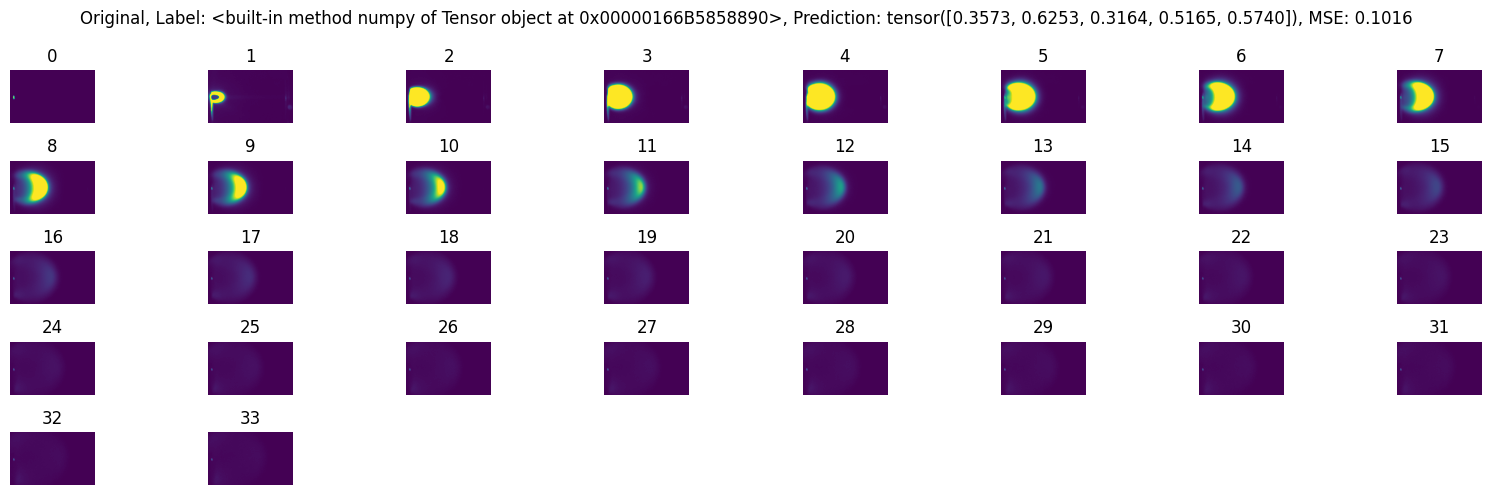

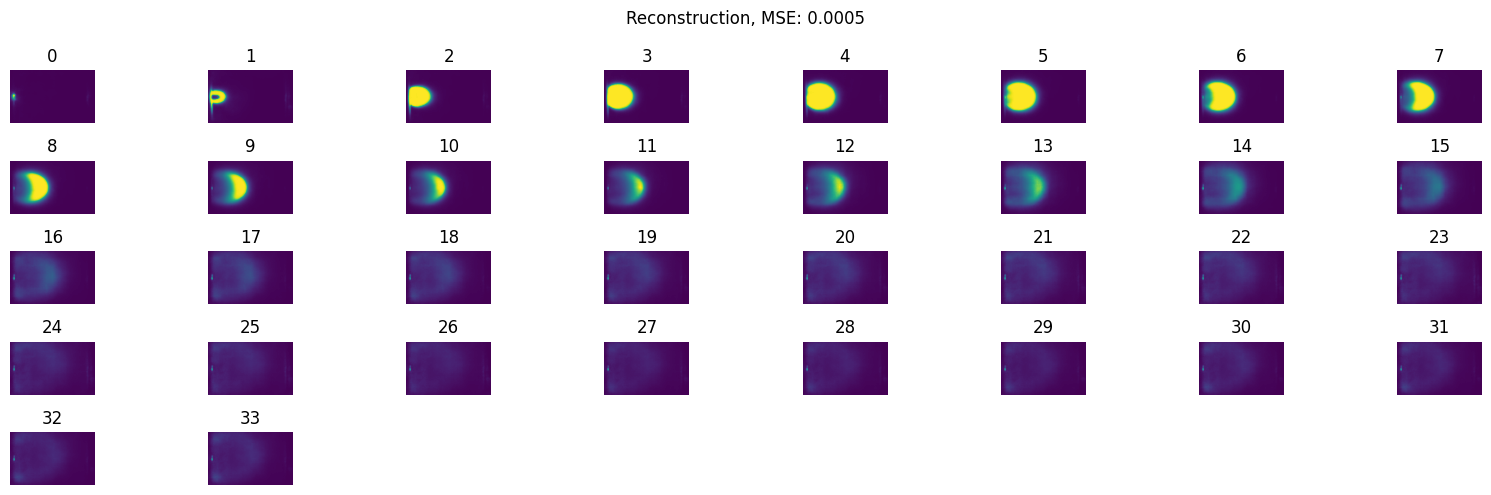

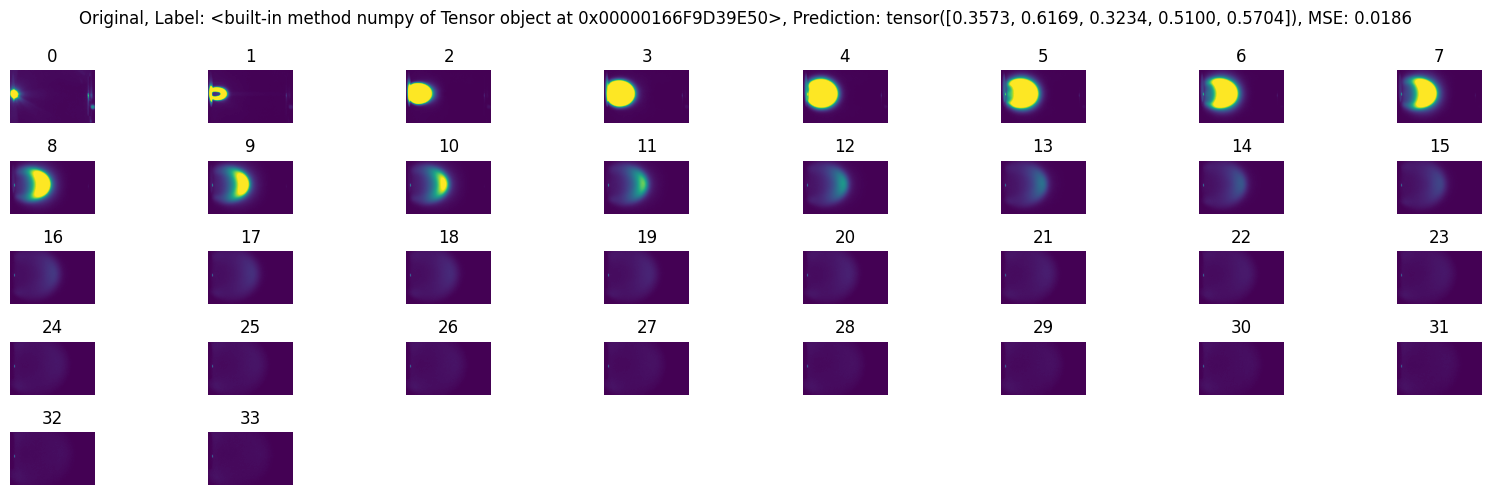

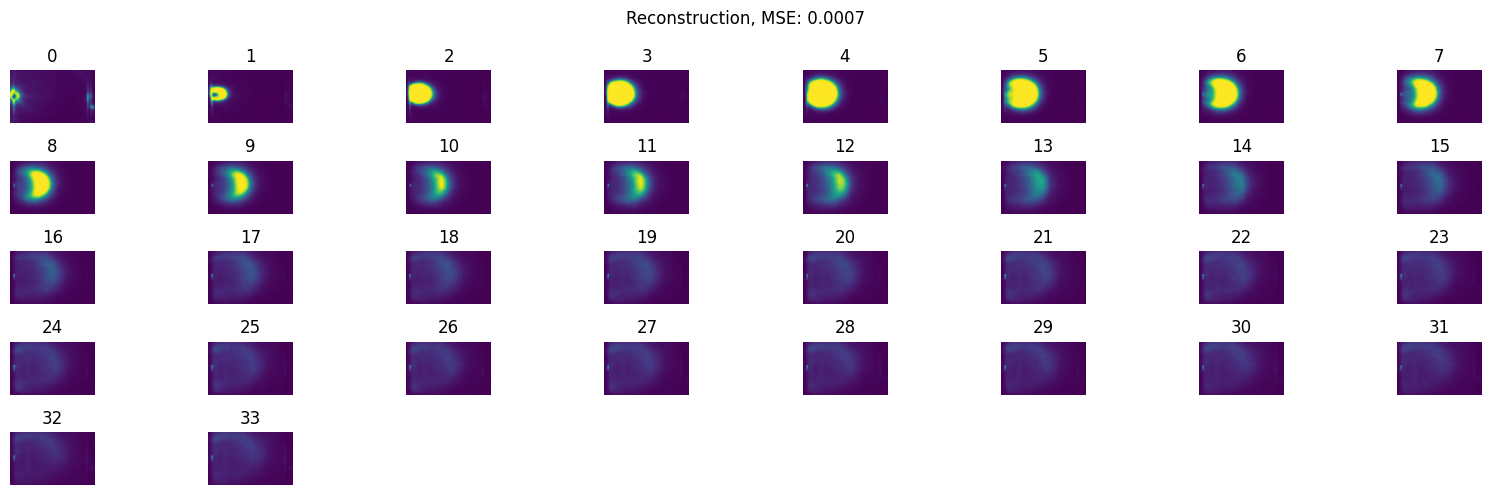

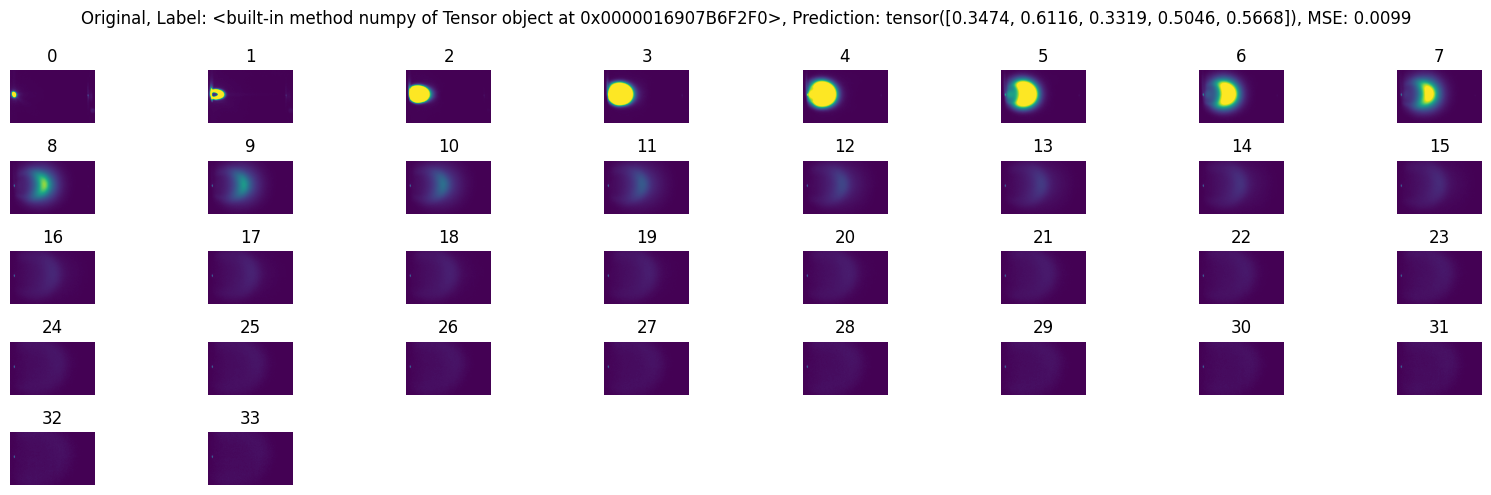

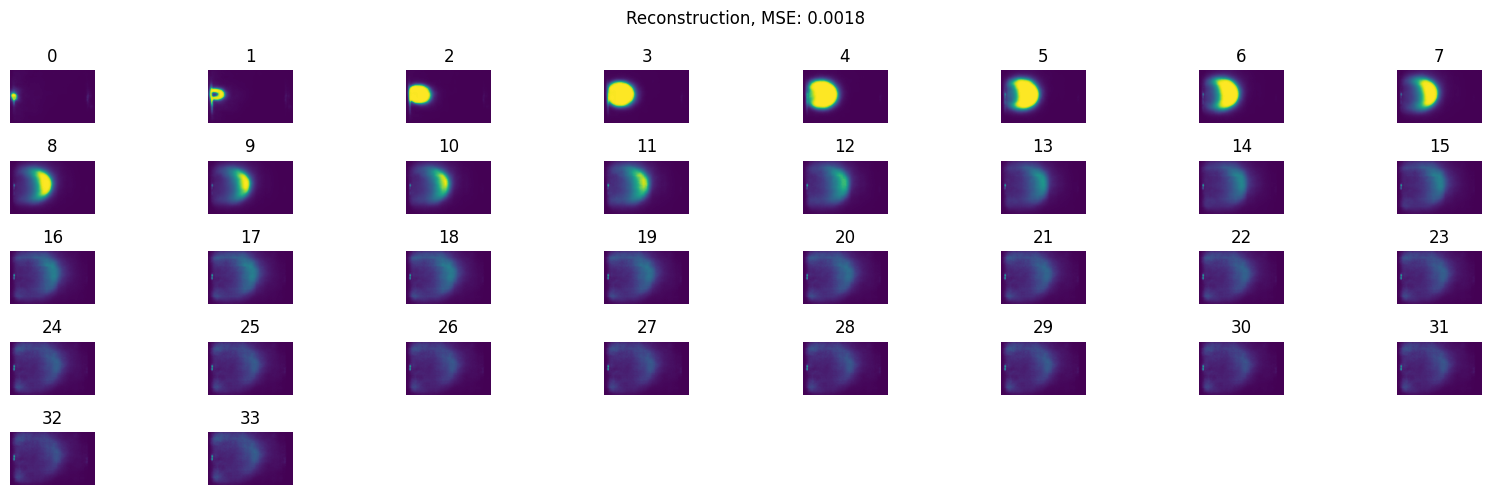

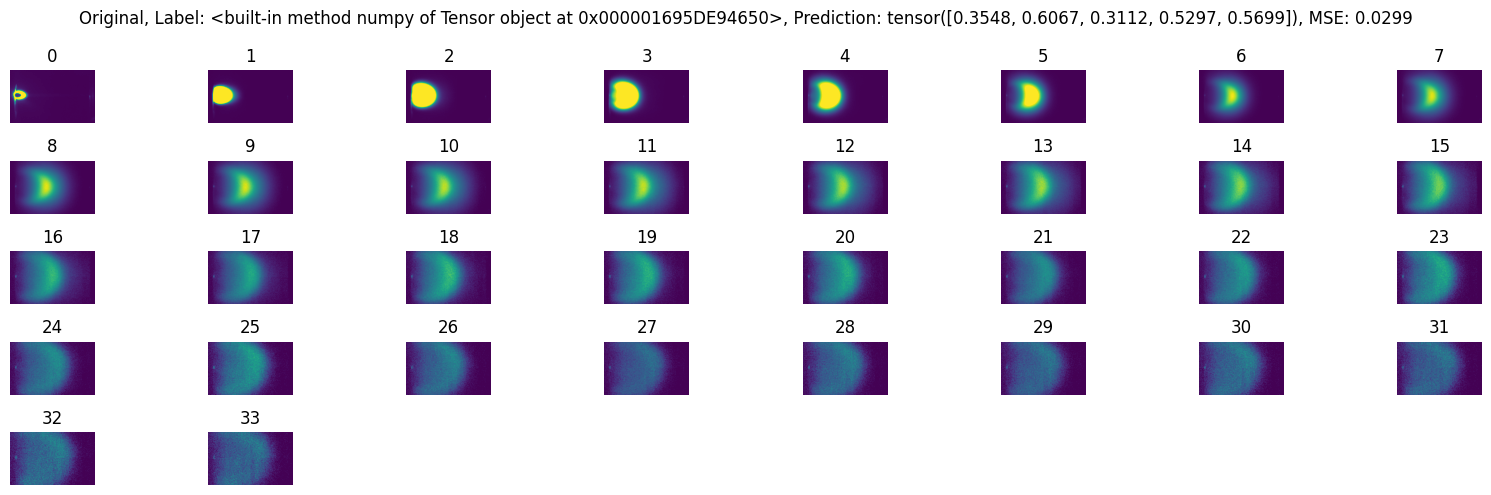

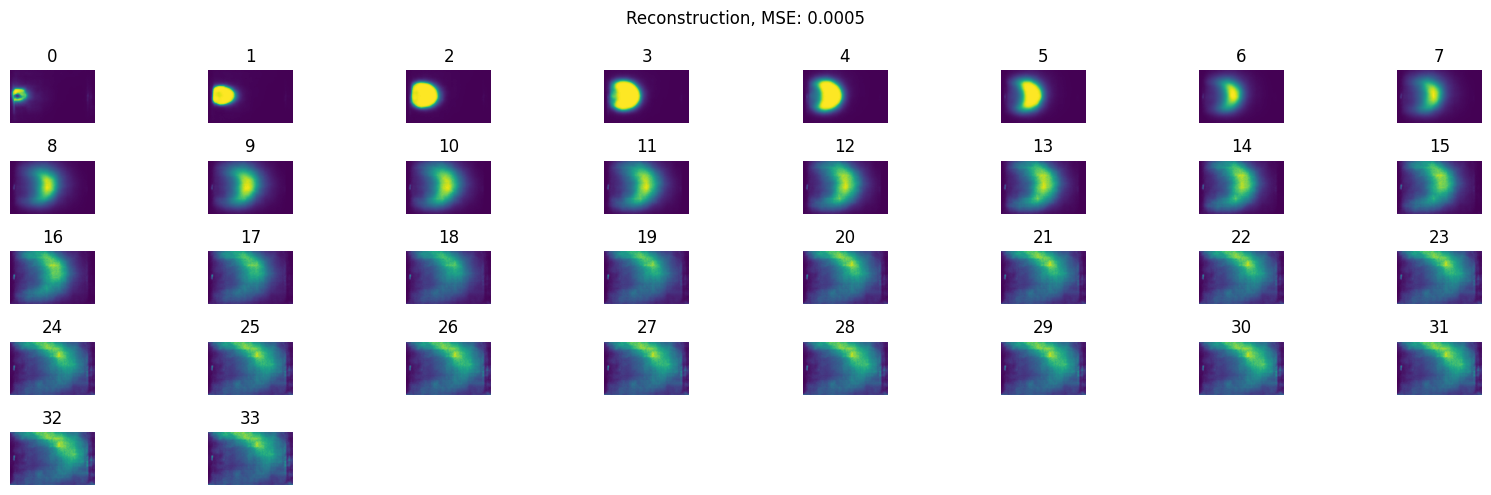

In [11]:
device = torch.device('cuda:0')
loss_func = nn.MSELoss()

batch = next(iter(train_dl))
images, labels = batch
images = images.to(device)
labels = labels.to(device)
model = model.to(device)
gr, reconstructed = model(images)
# images = images.squeeze().cpu().numpy()
# reconstructed = reconstructed.squeeze().cpu().detach().numpy()
print(gr.shape, labels.shape, images.shape, reconstructed.shape)

for i in range(len(images)):
    title = f'Original, Label: {labels[i].cpu().numpy}, Prediction: {gr[i].detach().cpu()}, MSE: {nn.MSELoss()(gr[i], labels[i]).item():.4f}'
    show_images(images.squeeze().cpu().numpy()[i], title=title)
    plt.show()
    
    title = f'Reconstruction, MSE: {loss_func(reconstructed[i], images[i]).item():.4f}'
    show_images(reconstructed.squeeze().detach().cpu().numpy()[i], title=title)
    plt.show()

torch.Size([4, 5]) torch.Size([4, 5]) torch.Size([4, 34, 1, 250, 400]) torch.Size([4, 34, 1, 250, 400])


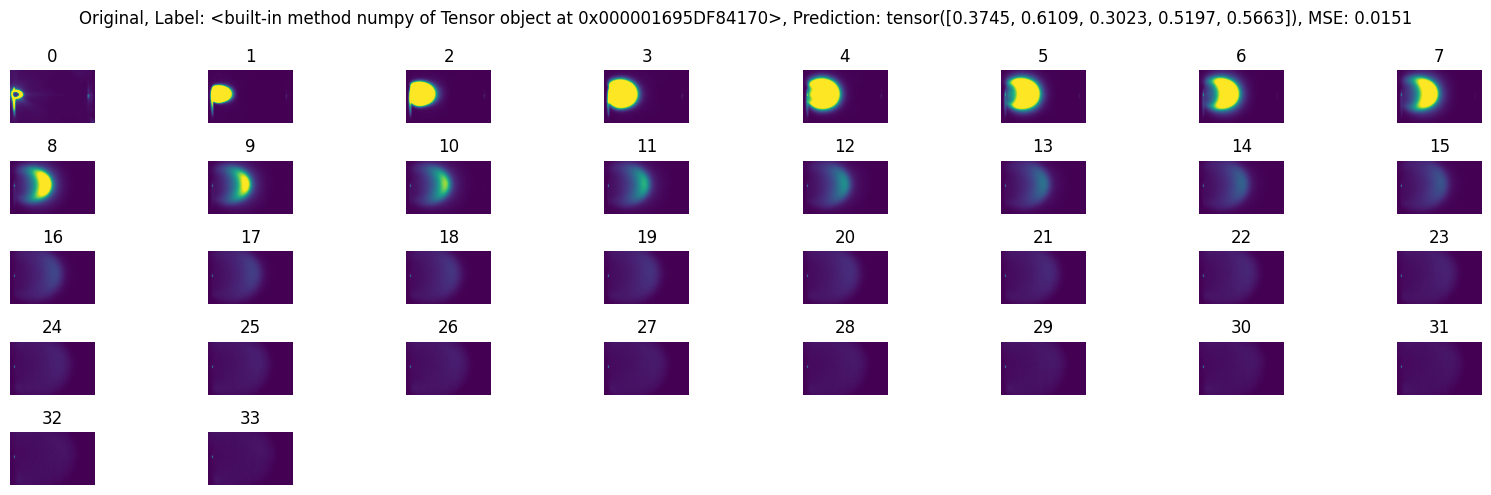

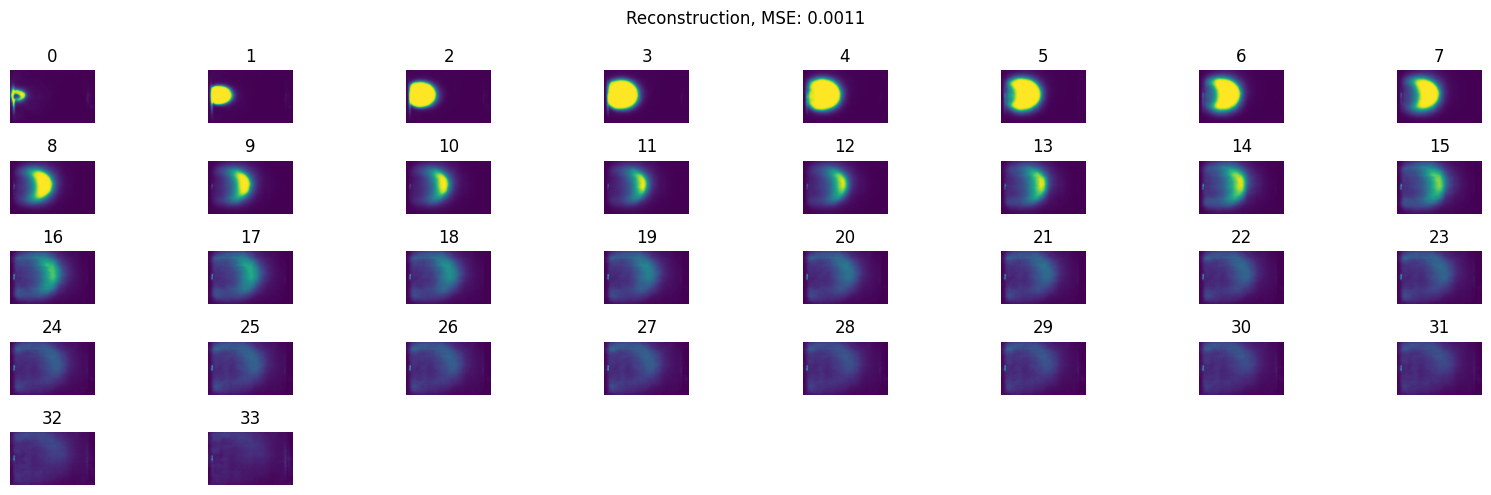

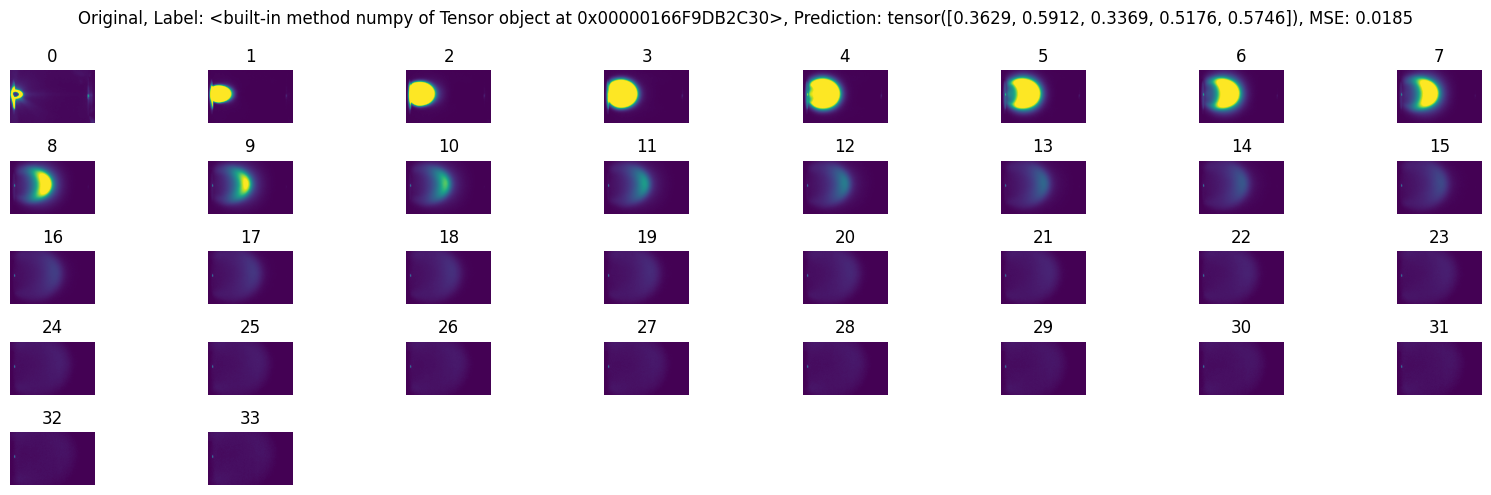

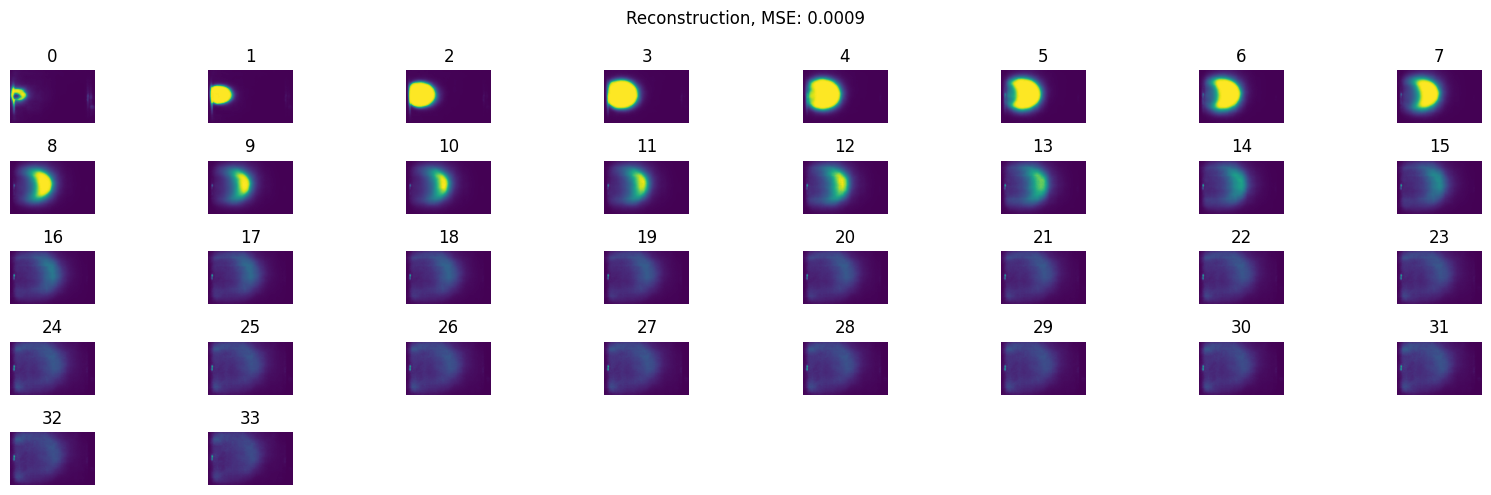

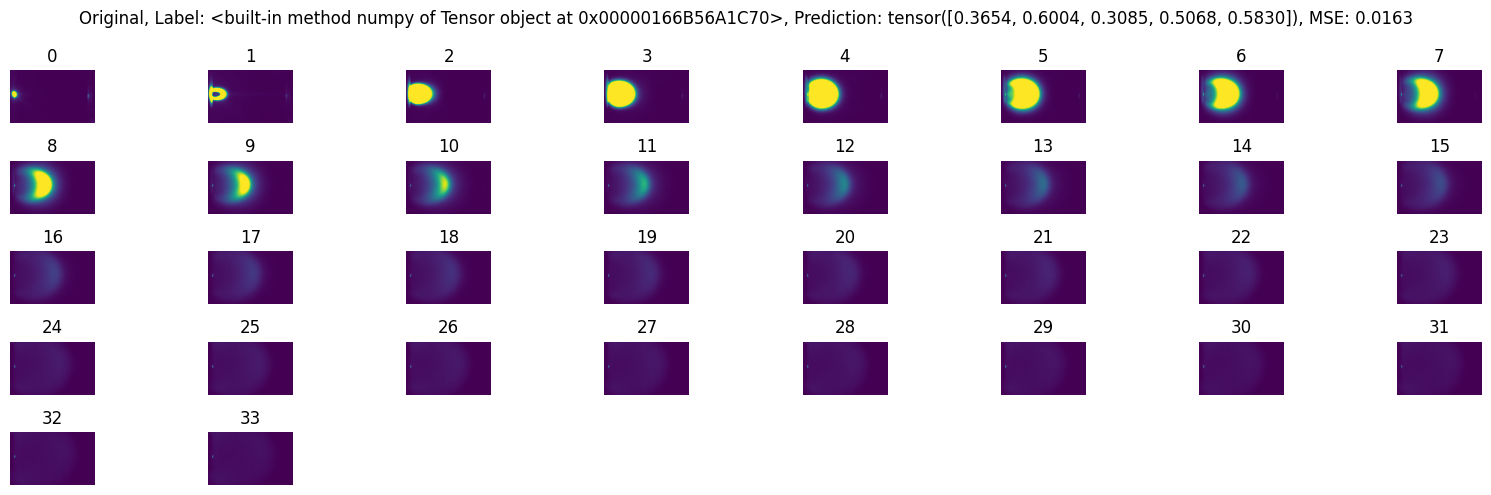

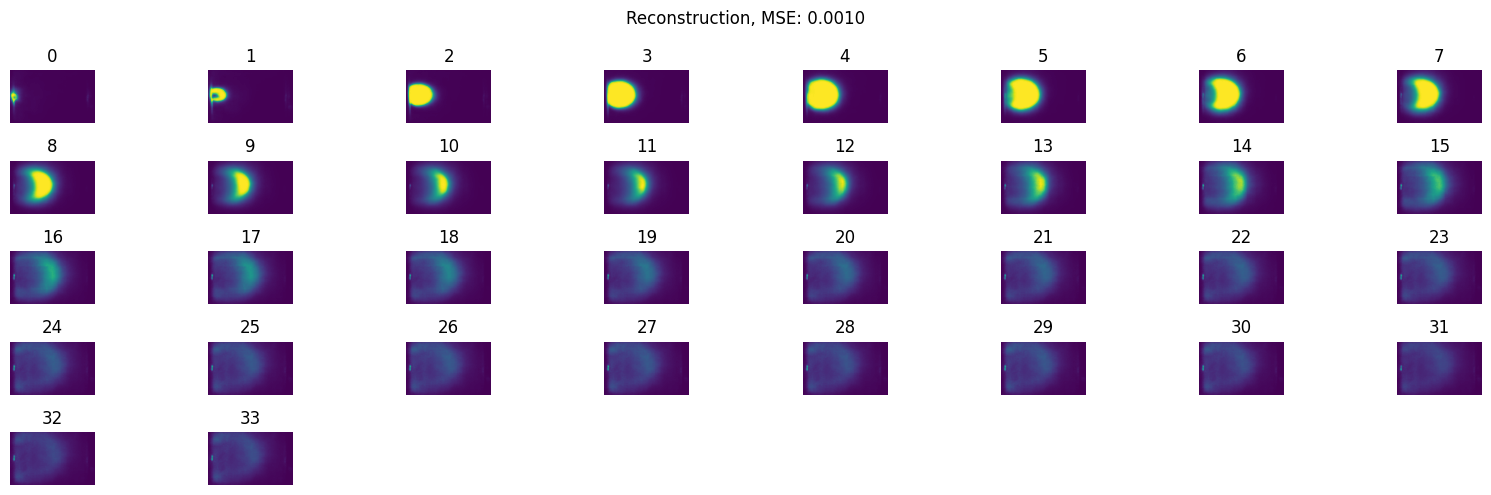

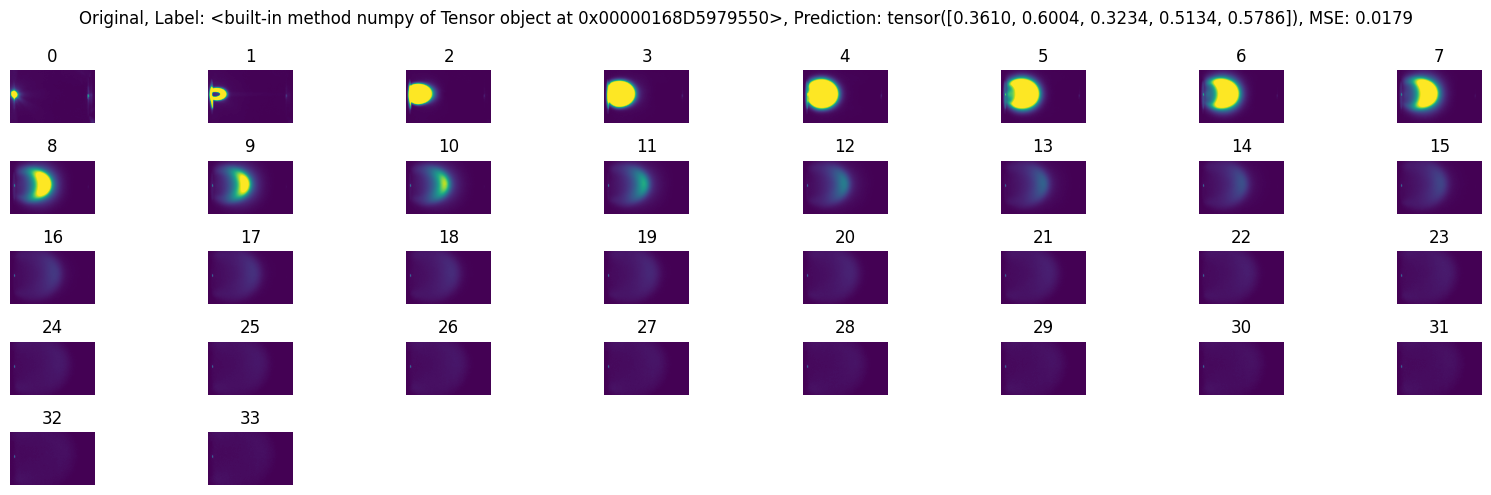

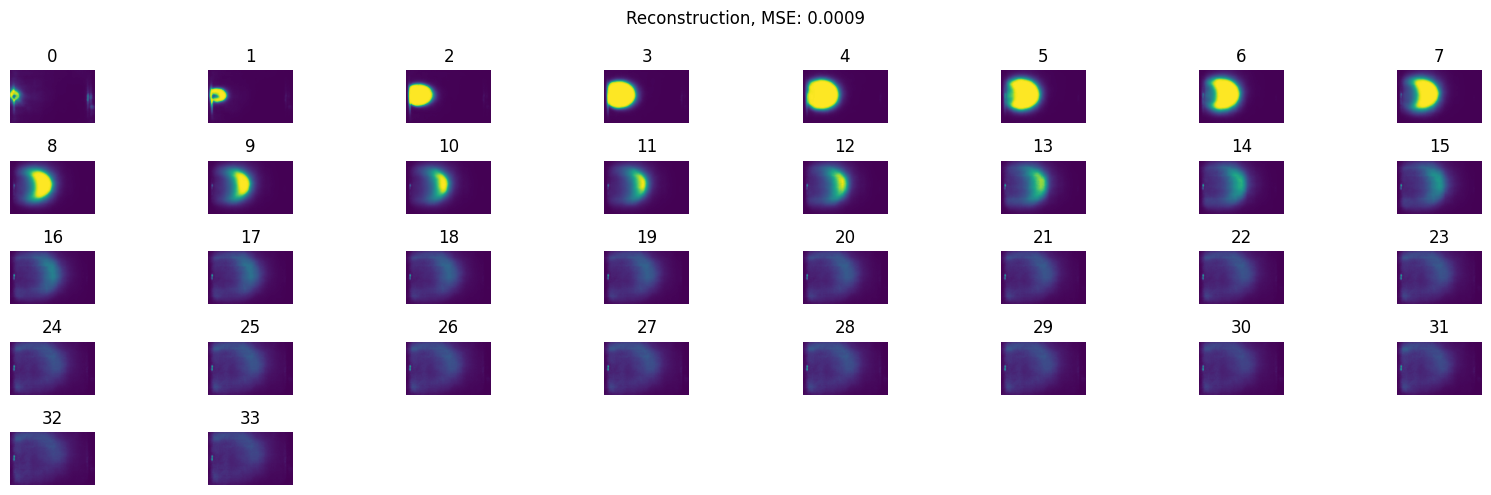

In [12]:
device = torch.device('cuda:0')
loss_func = nn.MSELoss()

batch = next(iter(valid_dl))
images, labels = batch
images = images.to(device)
labels = labels.to(device)
model = model.to(device)
gr, reconstructed = model(images)
# images = images.squeeze().cpu().numpy()
# reconstructed = reconstructed.squeeze().cpu().detach().numpy()
print(gr.shape, labels.shape, images.shape, reconstructed.shape)

for i in range(len(images)):
    title = f'Original, Label: {labels[i].cpu().numpy}, Prediction: {gr[i].detach().cpu()}, MSE: {nn.MSELoss()(gr[i], labels[i]).item():.4f}'
    show_images(images.squeeze().cpu().numpy()[i], title=title)
    plt.show()
    
    title = f'Reconstruction, MSE: {loss_func(reconstructed[i], images[i]).item():.4f}'
    show_images(reconstructed.squeeze().detach().cpu().numpy()[i], title=title)
    plt.show()